## Homework 3

by Quynh Anh Pham

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from functools import reduce
import scipy

%matplotlib inline

In [2]:
# ingesting data
df = pd.read_csv('data/hw3.csv', index_col=0)
df.head()
                 

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


Some reviews of our data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2667 entries, 2021-12-02 14:00:00 to 2021-12-06 07:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2667 non-null   float64
 1   high       2163 non-null   float64
 2   low        2378 non-null   float64
 3   close      2531 non-null   float64
 4   volume     2667 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2667 non-null   object 
 7   chain      2667 non-null   object 
dtypes: float64(6), object(2)
memory usage: 187.5+ KB


There seems to be a bunch of null values in our data




In [4]:
df['token'].value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

and some badly formatted tokens

In [5]:
df.duplicated().sum()

307

<AxesSubplot:xlabel='ts'>

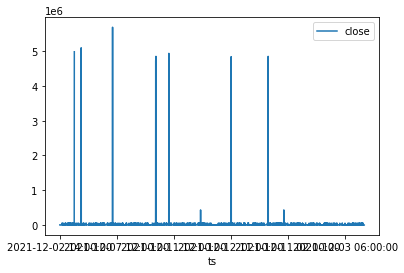

In [6]:
df[['token', 'close']].plot()

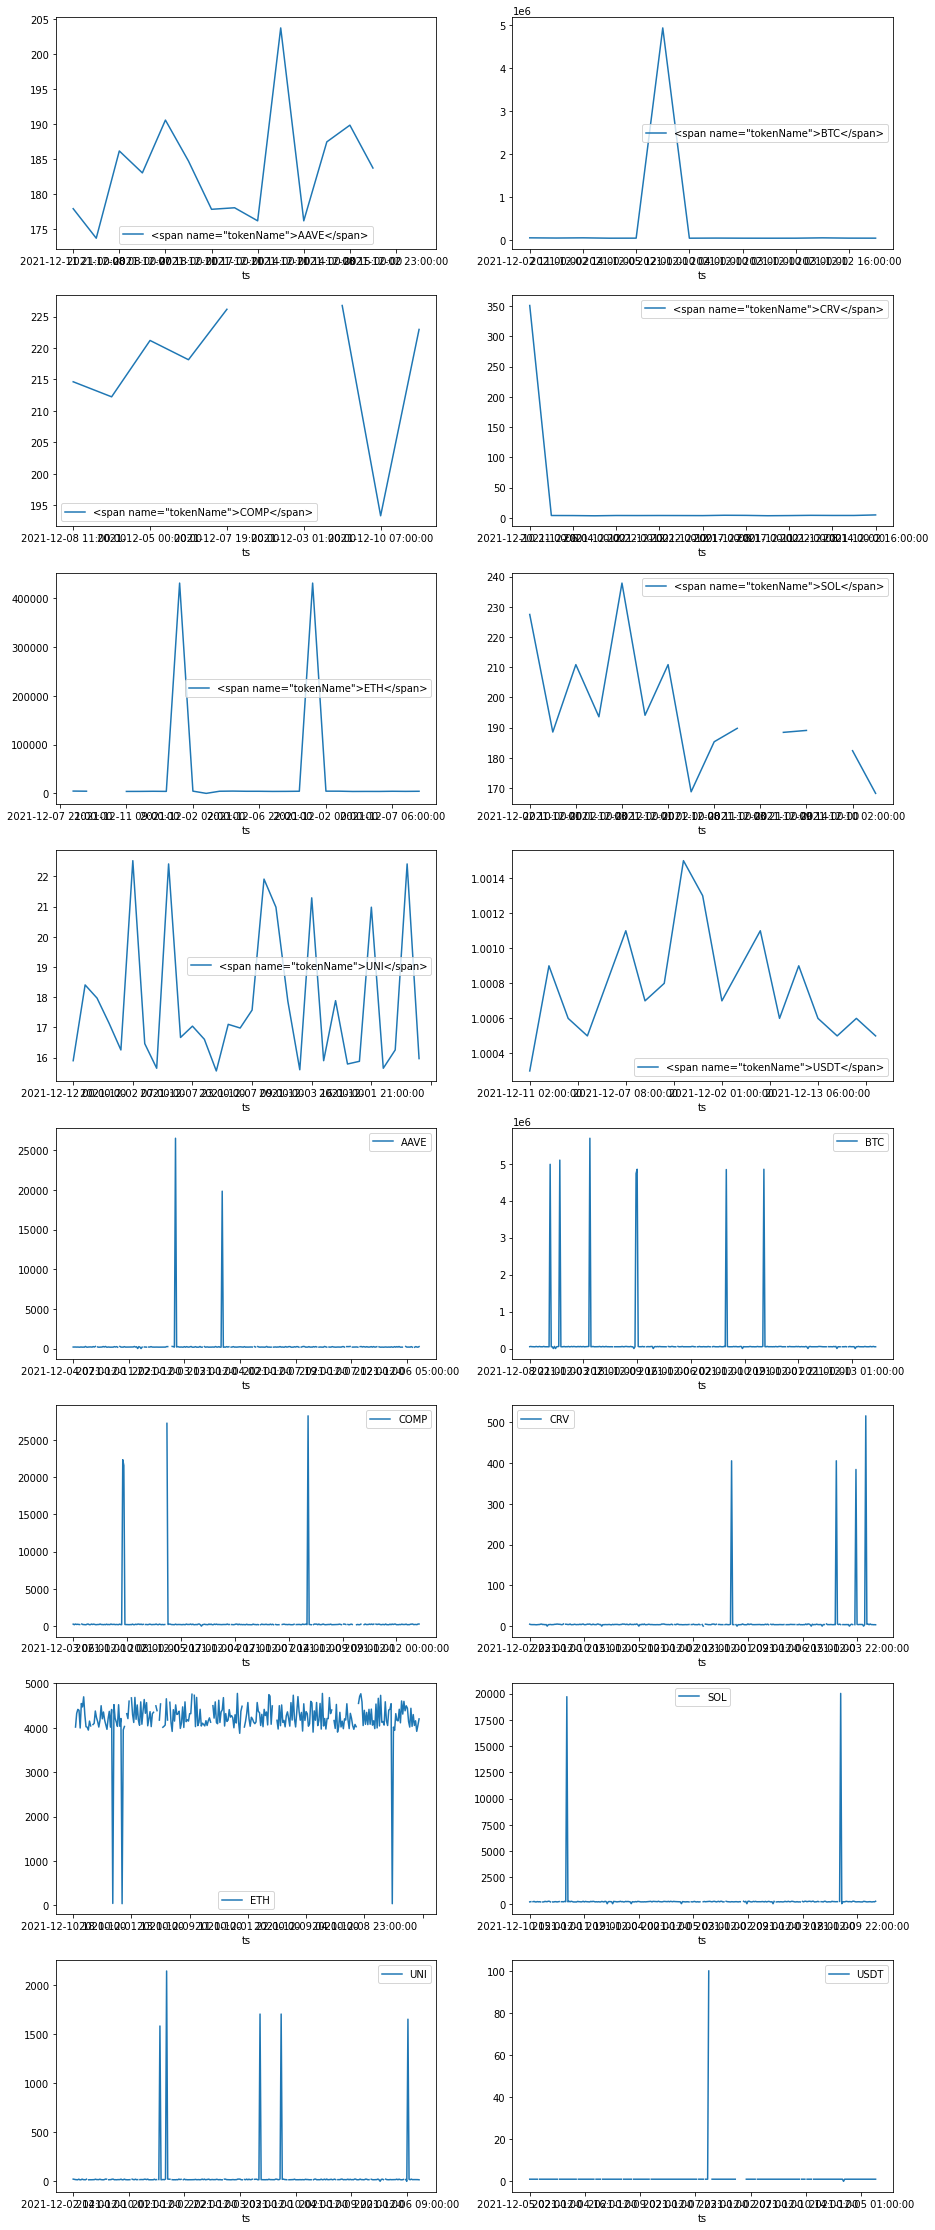

In [7]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


Few things we need to address with the data before finding volumeUSD:
1. Duplicates - to remove them
2. Incomprehensible names - to fix them
3. Strategy to fill in the missing values
4. Remove outliers

In [8]:
# 1 is the easy one
df = df.drop_duplicates()

In [9]:
# 2 reformat the names
df['token'] = np.where(df['token'].str.contains('span'),
                       df['token'].str.extract(r'<span.*?>(.*?)</span>',
                                               expand = False), 
                       df['token'])

In [10]:
df['token'].value_counts()

UNI     295
CRV     295
SOL     295
ETH     295
AAVE    295
USDT    295
COMP    295
BTC     295
Name: token, dtype: int64

In [11]:
# sort with timestamp
df = df.sort_values(['token','ts'])

In [12]:
# 3 check whether there are values needed to be cleaned
print(pd.isnull(df.low).any())
print(pd.isnull(df.high).any())
print(pd.isnull(df.close).any())
print(pd.isnull(df.volume).any())
print(pd.isnull(df.open).any())

True
True
True
False
False


In [13]:
# We can do forward fill for the same token, with the assumption that price won't move too much between timestamps

cols_to_fill = ['close', 'high','low']

for col in cols_to_fill:
    df[col] = df[col].fillna(method='ffill')
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,257.102,260.775,255.345,257.078,2730.299,NaN,AAVE,ETH
2021-12-01 01:00:00,257.149,266.249,255.270,264.816,5752.541,NaN,AAVE,ETH
2021-12-01 02:00:00,264.755,266.187,262.597,263.125,1559.330,NaN,AAVE,ETH
2021-12-01 03:00:00,263.184,266.187,262.597,266.257,1647.398,NaN,AAVE,ETH
2021-12-01 04:00:00,266.384,267.024,264.284,265.502,829.993,NaN,AAVE,ETH


In [14]:
# double check whether there are values needed to be cleaned
print(pd.isnull(df.low).any())
print(pd.isnull(df.high).any())
print(pd.isnull(df.close).any())
print(pd.isnull(df.volume).any())
print(pd.isnull(df.open).any())

False
False
False
False
False


In [15]:
df.loc[df.close / df.open >=2, 'close'] = 0.5 * (df.loc[df.close / df.open >=2, 'high']
                                                  + df.loc[df.close / df.open >=2 , 'low']
                                                 )

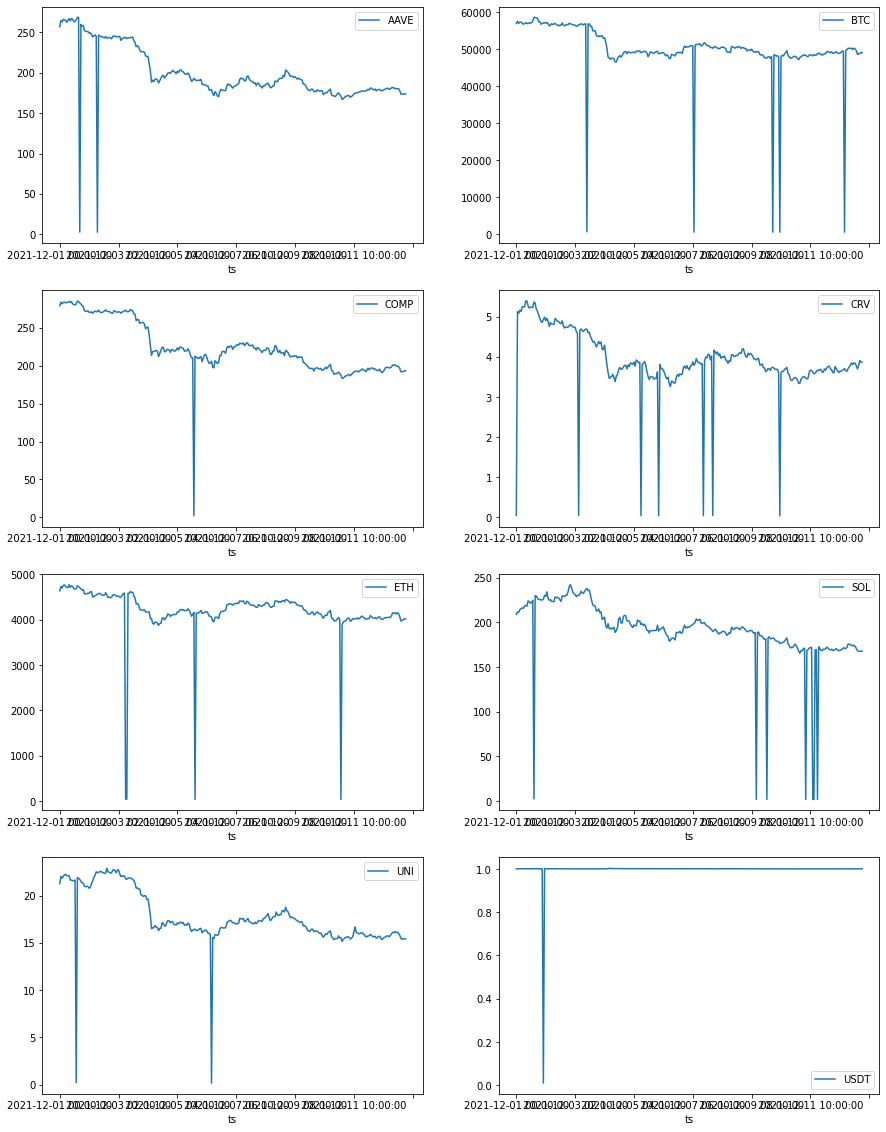

In [16]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

In [17]:
# looks much better now so calculate the volumeUSD
df['volumeUSD'] = df.volume*df.close
df

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299,7.018998e+05,AAVE,ETH
2021-12-01 01:00:00,257.1490,266.2490,255.2700,264.8160,5752.541,1.523365e+06,AAVE,ETH
2021-12-01 02:00:00,264.7550,266.1870,262.5970,263.1250,1559.330,4.102987e+05,AAVE,ETH
2021-12-01 03:00:00,263.1840,266.1870,262.5970,266.2570,1647.398,4.386312e+05,AAVE,ETH
2021-12-01 04:00:00,266.3840,267.0240,264.2840,265.5020,829.993,2.203648e+05,AAVE,ETH
...,...,...,...,...,...,...,...,...
2021-12-13 02:00:00,1.0005,1.0006,1.0004,1.0004,7133859.470,7.136713e+06,USDT,USDT
2021-12-13 03:00:00,1.0004,1.0006,1.0004,1.0006,4337884.530,4.340487e+06,USDT,USDT
2021-12-13 04:00:00,1.0006,1.0006,1.0004,1.0006,2928892.910,2.930650e+06,USDT,USDT


In [18]:
# final answer...
df.groupby('chain')['volumeUSD'].sum()

chain
BTC     1.085472e+10
ETH     1.357154e+10
SOL     4.007852e+09
USDT    1.004920e+09
Name: volumeUSD, dtype: float64